In [131]:
import numpy as np
import shap
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
pd.options.mode.chained_assignment = None
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

## Data Cleaning

In [132]:
train=pd.read_csv('train.csv')
train=train.drop('Id', axis = 1)
column_na=train.columns[train.isna().any()].tolist()
test=pd.read_csv('test.csv')

In [133]:
# Calculate the percentage of missing value in each column
per_na_l = []
for i in column_na:
    col_name = str(i)
    per_na = train[i].isnull().sum() * 100 / len(train) # get the percentage of NAs in each column
    per_na_l.append(per_na)
na_assess = pd.DataFrame(list(zip(column_na, per_na_l)), \
                         columns =['Variable Names', '% of NAs']).sort_values('% of NAs', ascending = False)


In [134]:
na_assess
## na_assess

,Variable Names,% of NAs
16,PoolQC,99.520548
18,MiscFeature,96.301370
1,Alley,93.767123
17,Fence,80.753425
10,FireplaceQu,47.260274
0,LotFrontage,17.739726
11,GarageType,5.547945
12,GarageYrBlt,5.547945
13,GarageFinish,5.547945
14,GarageQual,5.547945


In [135]:
train=train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis = 1)
test=test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis = 1)

### Impute Object Missing value with 'Not specified' and convert object to numeric

In [136]:
col_object=train.loc[:, train.dtypes == object].columns
le = preprocessing.LabelEncoder()
for i in col_object:
    train[i].fillna("Not Specified",inplace = True)
    train[i] = le.fit_transform(train[i].astype(str))

col_object_test=test.loc[:, test.dtypes == object].columns
le = preprocessing.LabelEncoder()
for i in col_object_test:
    test[i].fillna("Not Specified",inplace = True)
    test[i] = le.fit_transform(test[i].astype(str))

### Log transformation on Sale Price

In [137]:
train['SalePrice']=np.log(train['SalePrice'])

### Standardize data

In [138]:
train_st = pd.DataFrame(StandardScaler().fit_transform(train),columns=train.columns)
test_st= pd.DataFrame(StandardScaler().fit_transform(test),columns=test.columns)

### Impute Numeric Missing values with KNN

In [139]:
imputer = KNNImputer(n_neighbors=5)
train_st = pd.DataFrame(imputer.fit_transform(train_st),columns = train_st.columns)
test_st = pd.DataFrame(imputer.fit_transform(test_st),columns = test_st.columns)

In [140]:
train_st.columns[train_st.isna().any()].tolist()

[]

In [141]:
test_st.columns[test_st.isna().any()].tolist()

[]

## EDA

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([-3.91622807, -3.14635202, -2.37647596, -1.60659991, -0.83672386,
        -0.0668478 ,  0.70302825,  1.47290431,  2.24278036,  3.01265641,
         3.78253247]),
 <BarContainer object of 10 artists>)

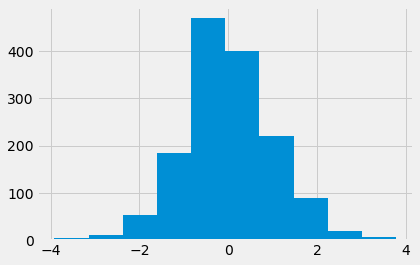

In [142]:
plt.hist(train_st['SalePrice'])

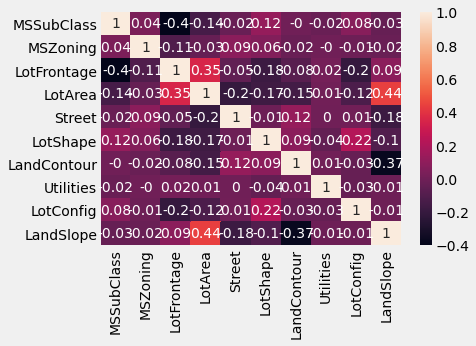

In [143]:
corr_matrix = round(train_st.iloc[:,0:10].corr(), 2)
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [144]:
train_st.corr()['SalePrice'].abs().sort_values(ascending=False)[0:20]

SalePrice       1.000000
OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
ExterQual       0.582163
BsmtQual        0.576968
YearRemodAdd    0.565608
GarageYrBlt     0.560845
TotRmsAbvGrd    0.534422
KitchenQual     0.534386
GarageType      0.503130
Fireplaces      0.489449
MasVnrArea      0.430966
HeatingQC       0.425906
GarageFinish    0.417404
Name: SalePrice, dtype: float64

In [145]:
key_var=train_st.corr()['SalePrice'].abs().sort_values(ascending=False)[0:10].index

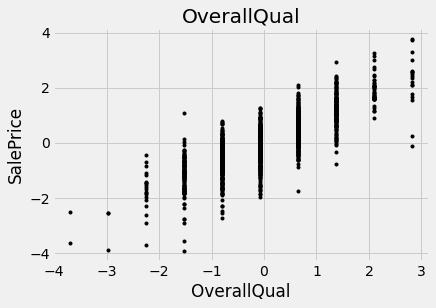

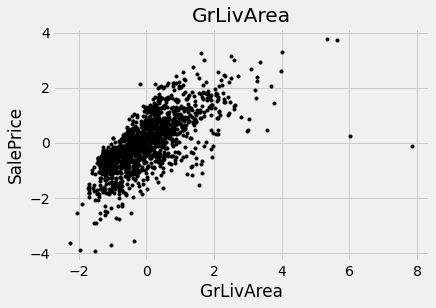

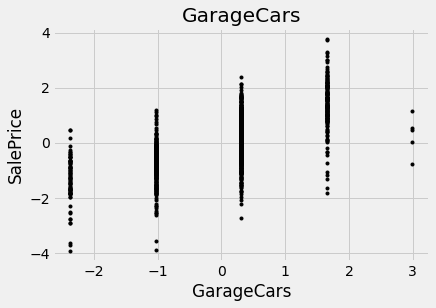

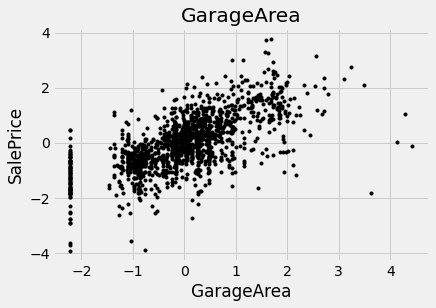

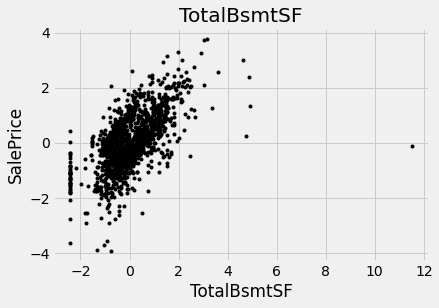

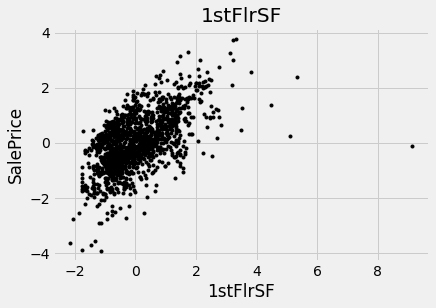

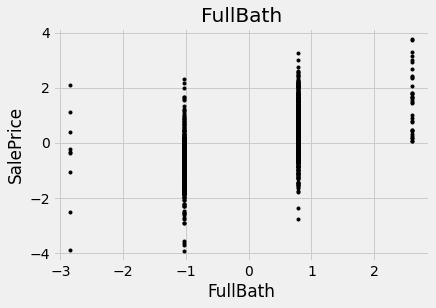

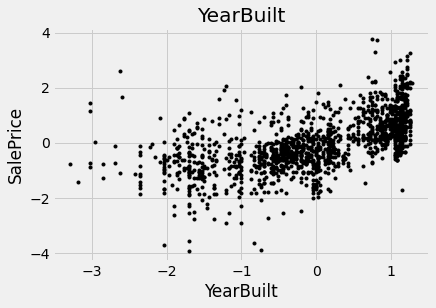

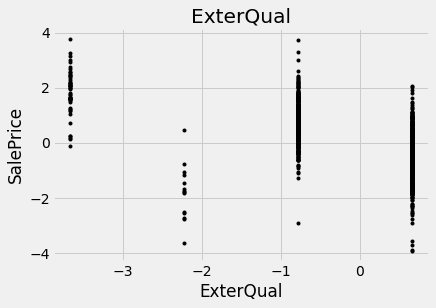

In [146]:
#looking at variable relationships through basic plots
for var in key_var:
    if var not in ['SalePrice']:  # Target_deathRate is y variable and Geography not numerical
        plt.plot(train_st[var], train_st['SalePrice'], '.', color='black')
        plt.title(var)
        plt.xlabel(var)
        plt.ylabel('SalePrice')
        plt.show()

## Train Test Split

In [147]:
X=train_st.drop('SalePrice', 1)
Y=train_st['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state = 42)

## OLS

In [148]:
LM = LinearRegression().fit(X_train,Y_train)

## Predict
sales_price_lm_train = LM.predict(X_train)
sales_price_lm_test = LM.predict(X_test)

## Evaluate
mae_lm=mean_absolute_error(Y_test,sales_price_lm_test)
r2_lm=r2_score(Y_test, sales_price_lm_test)

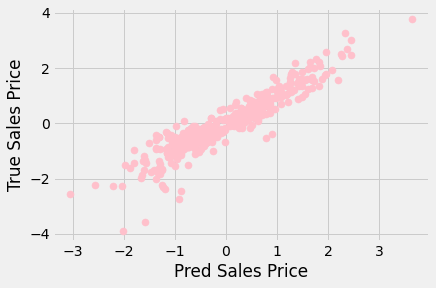

In [149]:
plt.scatter(sales_price_lm_test,Y_test, s = 50,color ='pink')
plt.xlabel('Pred Sales Price') 
plt.ylabel("True Sales Price") 
plt.show()

## CV Lasso

In [150]:
#fitting CV Lasso regression
Lasso = LassoCV(cv=10 ,normalize=False)
Lasso.fit(X_train, Y_train)

## Predict
sales_price_la_train =Lasso.predict(X_train)
sales_price_la_test = Lasso.predict(X_test)

## Evaluate
mae_la=mean_absolute_error(Y_test,sales_price_la_test)
r2_la=r2_score(Y_test, sales_price_la_test)

In [151]:
(Lasso.coef_!=0).sum()

33

In [152]:
Lasso.alpha_

0.02421740255508189

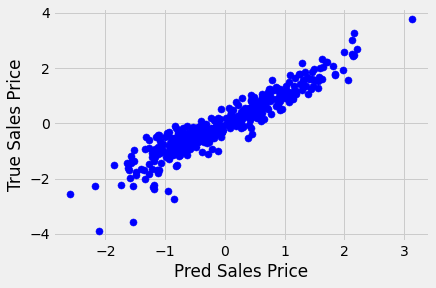

In [153]:
plt.scatter(sales_price_la_test,Y_test, s = 50,color ='blue')
plt.xlabel('Pred Sales Price') 
plt.ylabel("True Sales Price") 
plt.show()

## CV Ridge

In [154]:
#fitting CV Ridge regression
Ridge = RidgeCV(cv=10 ,normalize=False)
Ridge.fit(X_train, Y_train)

## Predict
sales_price_rd_train =Ridge.predict(X_train)
sales_price_rd_test =Ridge.predict(X_test)

## Evaluate
mae_rd=mean_absolute_error(Y_test,sales_price_rd_test)
r2_rd=r2_score(Y_test, sales_price_rd_test)

In [155]:
(Ridge.coef_!=0).sum()

74

In [156]:
Ridge.alpha_

10.0

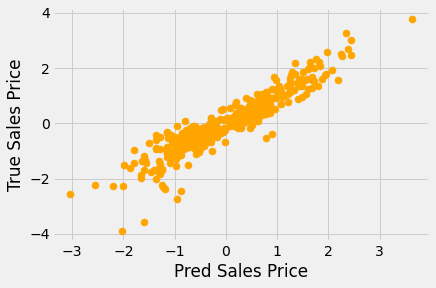

In [157]:
plt.scatter(sales_price_rd_test,Y_test, s = 50,color ='orange')
plt.xlabel('Pred Sales Price') 
plt.ylabel("True Sales Price") 
plt.show()

## Random Forest Regressor

In [158]:
feature_list = list(X.columns)
#fitting Random Forest Regressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, Y_train)
## Predict
predictions = rf.predict(X_test)
## Evaluate
errors = abs(predictions - Y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
r2_rf=r2_score(Y_test, predictions)
mae_rf=np.mean(errors)
baseline_preds = Y_test.mean()
baseline_errors = abs(baseline_preds - Y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Mean Absolute Error: 0.23
Average baseline error:  0.79


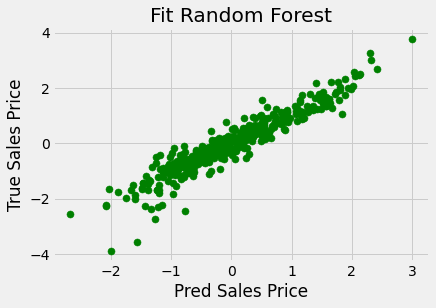

In [159]:
plt.scatter(predictions,Y_test, s = 50,color ='green')
plt.xlabel('Pred Sales Price') 
plt.ylabel("True Sales Price") 
plt.title("Fit Random Forest") 
plt.show()

### Tune Paramters

In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
from pprint import pprint
pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_tune = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_tune, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'n_estimators': [200, 400, 600, 800, 1000]}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.7min finished


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

In [45]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [47]:
rf_random.best_estimator_.fit(X_train, Y_train)
y_pred=rf_random.best_estimator_.predict(X_test)

### Feature Importance Score

In [160]:
feature_likes = pd.Series(rf.feature_importances_,index=train_st.drop('SalePrice', axis = 1).columns).sort_values(ascending=False).round(2)
feature_likes[0:15]

OverallQual     0.55
GrLivArea       0.10
GarageCars      0.04
TotalBsmtSF     0.04
GarageArea      0.03
BsmtFinSF1      0.02
1stFlrSF        0.02
LotArea         0.02
YearBuilt       0.01
GarageType      0.01
CentralAir      0.01
YearRemodAdd    0.01
OverallCond     0.01
2ndFlrSF        0.01
BsmtQual        0.01
dtype: float64

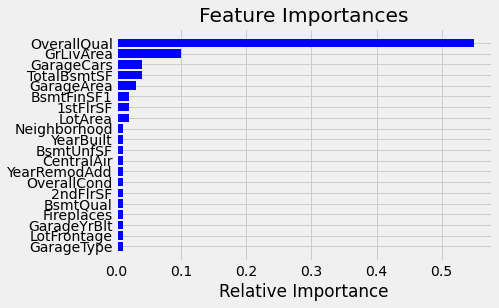

In [161]:
importances = feature_likes.values[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')

plt.yticks(range(len(indices)), [feature_likes.index[i] for i in indices])

plt.xlabel('Relative Importance')
plt.show()

In [162]:
shap.initjs()

In [165]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)

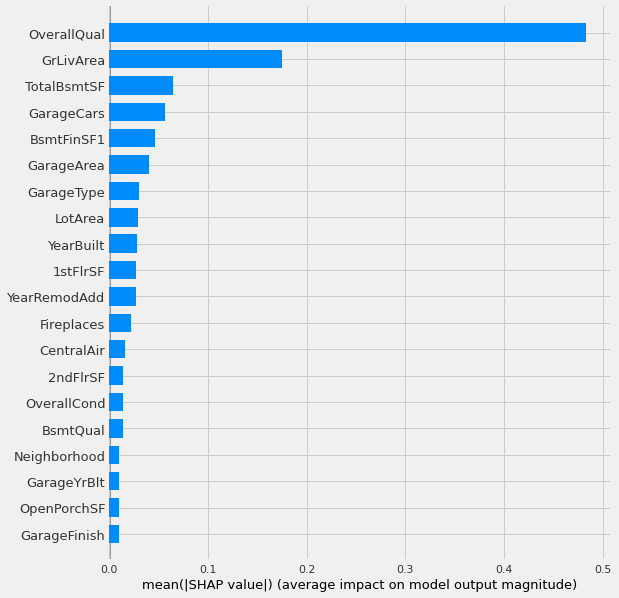

In [166]:
shap.summary_plot(shap_values, X_train, plot_type="bar",feature_names=train_st.columns)

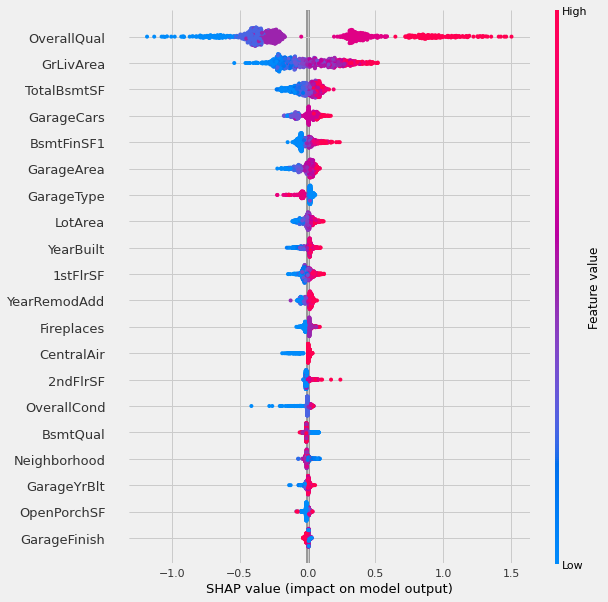

In [167]:
shap.summary_plot(shap_values, X_train,feature_names=train_st.columns)

In [168]:
# Get the predictions and put them with the test data.
X_output = pd.DataFrame(X_test.copy())
X_output.loc[:,'predict'] = np.round(rf.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]

In [169]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]],feature_names=train_st.columns)
    return(p)

In [170]:
shap_plot(0) 

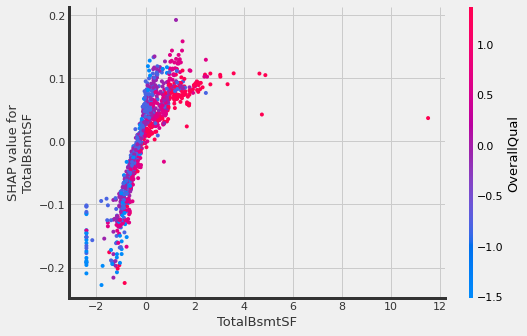

In [171]:
shap.dependence_plot('TotalBsmtSF', shap_values, X_train,feature_names=train_st.columns)

## Use PCR to Predict Sale Price

In [172]:
pca = PCA(n_components=10)
X_PCA_train=pca.fit_transform(X_train)

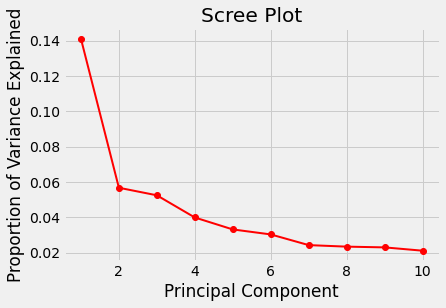

In [173]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [174]:
mse = []
for i in np.arange(1, 70):
    
    pca = PCA(n_components= i)
    pca.fit(X_train)
    X_train_ = pca.transform(X_train)
    X_test_ = pca.transform(X_test)
    linreg = LassoCV(cv=10 ,normalize=False)
    linreg.fit(X_train_, Y_train)
    
    #fitting linear regression
    scores = cross_val_score(linreg, X_test_,Y_test, scoring='neg_mean_squared_error', cv=10, n_jobs=-1).mean()
    scores = abs(scores) 
    mse.append(scores)

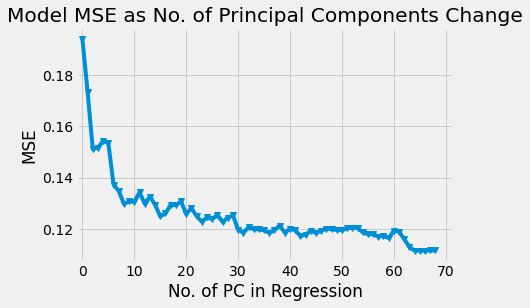

In [175]:
# Plot results    
plt.plot(mse,'-v')
plt.xlabel('No. of PC in Regression')
plt.ylabel('MSE')
plt.title('Model MSE as No. of Principal Components Change')
plt.xlim(xmin=-1);

In [176]:
pct_var_rate=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
pct_var_rate

array([14.12, 19.8 , 25.05, 29.05, 32.37, 35.42, 37.86, 40.21, 42.52,
       44.69, 46.69, 48.61, 50.46, 52.3 , 54.06, 55.78, 57.46, 59.08,
       60.63, 62.17, 63.64, 65.09, 66.53, 67.87, 69.18, 70.46, 71.7 ,
       72.94, 74.1 , 75.25, 76.38, 77.48, 78.55, 79.57, 80.59, 81.58,
       82.53, 83.42, 84.3 , 85.16, 85.98, 86.78, 87.57, 88.34, 89.09,
       89.82, 90.51, 91.17, 91.8 , 92.42, 93.  , 93.56, 94.11, 94.61,
       95.1 , 95.56, 96.01, 96.43, 96.83, 97.22, 97.58, 97.93, 98.24,
       98.54, 98.82, 99.09, 99.32, 99.5 , 99.66])

In [177]:
pct_var_rate[10] ## optimal number of components= 10/ 47%

46.69

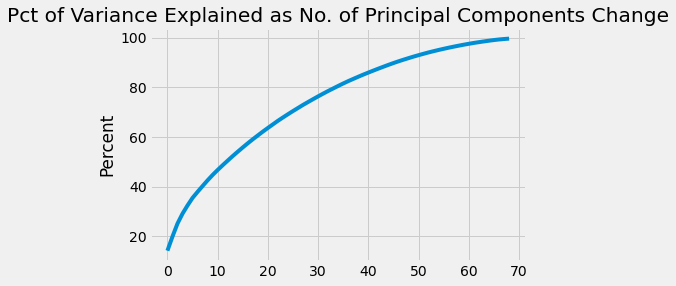

In [178]:
import matplotlib.pyplot as plt
plt.plot(pct_var_rate)
plt.ylabel('Percent')
plt.title('Pct of Variance Explained as No. of Principal Components Change')
plt.show()

### PCA with 47% variance explainable +CV Lasso

In [179]:
pca = PCA(.47)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


#fitting linear regression
linreg = LassoCV(cv=10 ,normalize=False)
linreg.fit(X_train, Y_train)

## Predict
sales_price_PCA_train =linreg.predict(X_train)
sales_price_PCA_test =linreg.predict(X_test)


## Evaluate
mae_pcr=mean_absolute_error(Y_test,sales_price_PCA_test)
r2_pcr=r2_score(Y_test, sales_price_PCA_test)

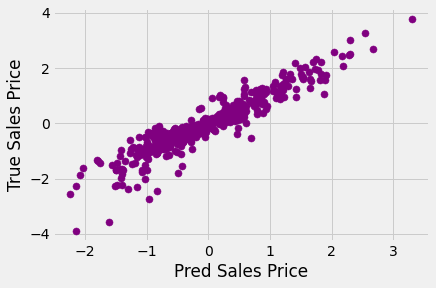

In [180]:
plt.scatter(sales_price_PCA_test,Y_test, s = 50,color ='purple')
plt.xlabel('Pred Sales Price') 
plt.ylabel("True Sales Price") 
plt.show()

## Use Neural Network to predict sale price

In [181]:
regr = MLPRegressor(random_state=1,max_iter=1000)
from sklearn.model_selection import GridSearchCV
param_grid= dict(activation=['tanh','identity', 'logistic','relu'],hidden_layer_sizes=[(25, 9, 3),(25, 9),(25)])
grid=GridSearchCV(estimator=regr, param_grid=param_grid,n_jobs=-1, cv=10) 
grid_result = grid.fit(X_train, Y_train)
sales_price_nn_test=grid_result.predict(X_test)
sales_price_nn_train=grid_result.predict(X_train)
r2_nn = grid_result.score(X_test, Y_test) 
mae_nn=mean_absolute_error(Y_test,sales_price_nn_test)

In [182]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.854557 using {'activation': 'logistic', 'hidden_layer_sizes': (25, 9)}
0.780081 (0.036164) with: {'activation': 'tanh', 'hidden_layer_sizes': (25, 9, 3)}
0.803031 (0.048146) with: {'activation': 'tanh', 'hidden_layer_sizes': (25, 9)}
0.819110 (0.036323) with: {'activation': 'tanh', 'hidden_layer_sizes': 25}
0.812208 (0.114397) with: {'activation': 'identity', 'hidden_layer_sizes': (25, 9, 3)}
0.815120 (0.117347) with: {'activation': 'identity', 'hidden_layer_sizes': (25, 9)}
0.813242 (0.116577) with: {'activation': 'identity', 'hidden_layer_sizes': 25}
0.853126 (0.024496) with: {'activation': 'logistic', 'hidden_layer_sizes': (25, 9, 3)}
0.854557 (0.030889) with: {'activation': 'logistic', 'hidden_layer_sizes': (25, 9)}
0.851641 (0.030903) with: {'activation': 'logistic', 'hidden_layer_sizes': 25}
0.818689 (0.065695) with: {'activation': 'relu', 'hidden_layer_sizes': (25, 9, 3)}
0.818405 (0.062876) with: {'activation': 'relu', 'hidden_layer_sizes': (25, 9)}
0.820207 (0.090364) 

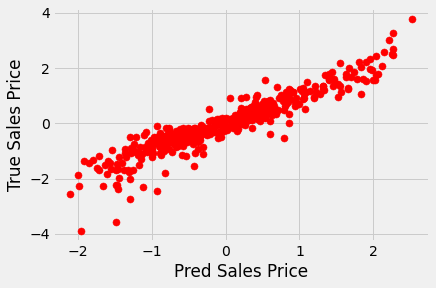

In [183]:
plt.scatter(sales_price_nn_test,Y_test, s = 50,color ='red')
plt.xlabel('Pred Sales Price') 
plt.ylabel("True Sales Price") 
plt.show()

## Compare different models

In [184]:
r2=[r2_lm,r2_la, r2_rd,r2_rf,r2_pcr,r2_nn]
mae=[mae_lm,mae_la,mae_rd,mae_rf,mae_pcr,mae_nn]

In [185]:
pd.DataFrame([r2, mae], columns=['LM','Lasso', 'Ridge','Random Forest','PCR','Neural Network'],index=['R-Squared','MAE']).round(3)

,LM,Lasso,Ridge,Random Forest,PCR,Neural Network
R-Squared,0.868,0.872,0.869,0.890,0.872,0.874
MAE,0.267,0.264,0.266,0.233,0.258,0.257


## Predict using the best model

In [186]:
pred_holdout = rf.predict(test_st.drop('Id', axis = 1))
pred_holdout=pd.DataFrame(np.exp(pred_holdout))
pred_holdout.to_csv("Holdout_sale_price.csv")

## Use K-Means to find hidden properties of train dataset

In [94]:
from sklearn.cluster import KMeans
kmeans_fix = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}

In [95]:
ssd = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_fix)
    kmeans.fit(train_st)
    ssd.append(kmeans.inertia_)

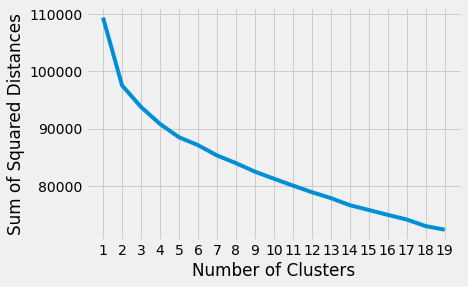

In [96]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), ssd)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances")
plt.show()

In [97]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 20), ssd, curve="convex", direction="decreasing")
kl.elbow

5

In [98]:
kmeans = KMeans(init="random",n_clusters=5,n_init=10, max_iter=300,random_state=42)
kmeans.fit(train_st)

KMeans(init='random', n_clusters=5, random_state=42)

In [99]:
# The lowest SSE value
kmeans.inertia_

88493.42166040067

In [100]:
# Final locations of the centroid
## kmeans.cluster_centers_

In [101]:
# first 5 predicted labels
kmeans.labels_[:5]

array([0, 3, 0, 3, 0], dtype=int32)

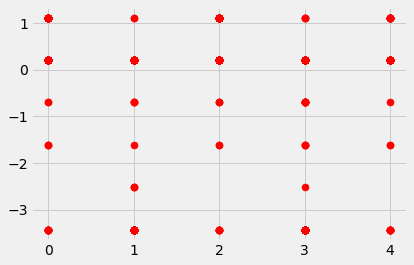

In [102]:
plt.scatter(kmeans.labels_,train_st['SaleCondition'],s = 50,color ='red')
plt.show()

In [103]:
cluster=pd.DataFrame(kmeans.labels_,columns=['cluster'])

In [104]:
cluster[train_st.columns]=train_st

<AxesSubplot:xlabel='cluster', ylabel='EnclosedPorch'>

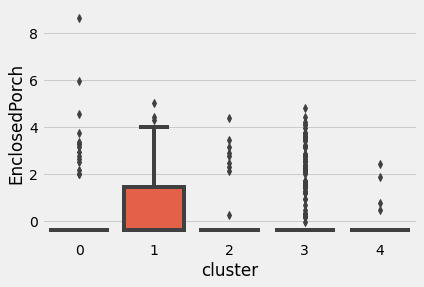

In [105]:
sns.boxplot(x=cluster['cluster'], y=cluster['EnclosedPorch'], data=cluster)
## Preference on EnclosedPorch indicates cluster 1

<AxesSubplot:xlabel='cluster', ylabel='SalePrice'>

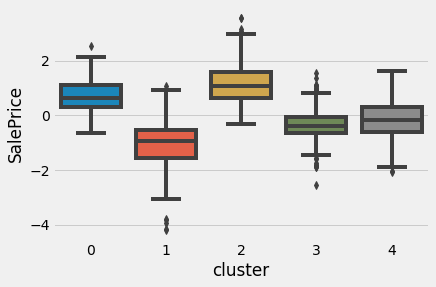

In [106]:
sns.boxplot(x=cluster['cluster'], y=cluster['SalePrice'], data=cluster)